In [1]:
# pip install torch torchvision torchaudio numpy pandas matplotlib scikit-learn tqdm requests pyyaml pyarrow

# Восстановление пропущенных пробелов в тексте

Тестовое задание от Авито

Иванов Максим (moxeeeem@gmail.com)

На Авито пользователи часто вводят тексты в поиске, описаниях или заголовках с опечатками, 
пропущенными пробелами или слитным написанием слов (например: книгавхорошемсостоянии).
Такие тексты усложняют понимание, снижают качество поиска и мешают автоматическому анализу 
(например, извлечению сущностей). 

Да, можно просто использовать дорогую LLM модель, но как будто такая задача может решаться 
гораздо более дешевым и быстрым способом. Мы ищем именно такое решение - точное, быстрое и легковесное.

Задача — разработать модель или алгоритм, который принимает на вход текст без пробелов и 
возвращает восстановленный текст с правильными пробелами и позициями, где они были пропущены. 

**Метрика**

Качество оценивается по F1-score для позиций пропущенных пробелов.

Для каждой строки мы сравниваем множество позиций, где вы поставили пробелы, с истинным множеством.

Формула: 

$$\text{F1} = 2 * \frac{\text{precision} * \text{recall}}{\text{precision} + \text{recall}}$$

где:

$$\text{precision} = \frac{|\text{предсказанные} \cap \text{истинные}|}{|\text{предсказанные}|}$$
$$\text{recall} = \frac{|\text{предсказанные} \cap \text{истинные}|}{|\text{истинные}|}$$

Окончательная метрика — средний F1 по всем текстам.

**Таблица метрик**

|                   | Train      | Validation    | Test (Submission)    |
|-------------------|------------|---------------|----------------------|
| Number of samples | 395943     | 43994         | 1005                 |
| F1-score          | -          | -             | 93.614%              |
| Time (sec)        | -          | -             | 10.0                 |


**Описание подхода**

Представленное решение базируется на статье - [Fast Whitespace Correction with Encoder-Only Transformers](https://aclanthology.org/2023.acl-demo.37/).
Это SOTA подход для задачи восстановления пробелов, опубликованный в 2023 году.

Его главное преимущество и особенность - быстрота и лёгкость модели (вариант с Encoder-Only Transformer), что позволяет использовать её в продакшене с ограниченными ресурсами. Это именно наш случай, когда нужно быстро и эффективно исправлять тексты пользователей.

Основная идея модели заключается в том, чтобы рассматривать исправление пробелов не как генерацию нового текста, а как задачу классификации. Модель для каждого символа в тексте параллельно решает, что с ним сделать: оставить, удалить или вставить перед ним пробел, что делает ее чрезвычайно быстрой.

**Экспериментальная среда**

Все эксперименты проводились на машине со следующими характеристиками:
- Оперативная память: 47 GB
- Графический процессор: NVIDIA RTX A4000 (16 GB видеопамяти)
- Время прогона всего ноутбука от начала и до конца: 00 минут

## Настройка окружения

Начнём с импортов и простых настроек логов - все дальнейшие разделы будем пользоваться этими зависимостями

In [2]:
from __future__ import annotations

import ast
import gc
import gzip
import io
import json
import logging
import math
import os
import random
import re
import sys
import time
import unicodedata
import zipfile
from dataclasses import dataclass
from contextlib import contextmanager
from pathlib import Path
from collections.abc import Iterable, Iterator, Sequence

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import yaml
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

/home/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')
logger = logging.getLogger('whitespace')

In [4]:
warnings_to_silence = [
    'enable_nested_tensor is True, but self.use_nested_tensor is False',
]
for warning_message in warnings_to_silence:
    logging.captureWarnings(True)

In [5]:
IPYNB_TIME_START = time.time()
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / 'avito_parts'
NEWS_CACHE = PROJECT_ROOT / 'ru_news_short.txt'
RANDOM_STATE = 42
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
AMP = DEVICE == 'cuda'

In [6]:
torch.backends.cuda.matmul.allow_tf32 = True
if torch.cuda.is_available():
    torch.set_float32_matmul_precision('high')

In [7]:
logger.info('Работаем на устройстве: %s', DEVICE)

2025-09-24 17:33:47,447 INFO: Работаем на устройстве: cuda


Подавляем предупреждение PyTorch, которое возникло из-за копирования логики из статьи

In [8]:
import warnings

for warning_message in warnings_to_silence:
    warnings.filterwarnings('ignore', message=warning_message)

Чтобы результаты можно было воспроизвести, фиксируем случайные сиды

In [9]:
def set_global_seed(seed: int) -> None:
    '''
    Фиксирует генераторы случайных чисел Python, NumPy и PyTorch.

    Parameters
    ----------
    seed : int
        Значение, используемое для инициализации псевдослучайных генераторов.

    Returns
    -------
    None
        Функция не возвращает значение и выполняет настройку генераторов на месте.
    '''
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)


set_global_seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True
logger.info('Фиксируем генераторы случайных чисел значением %d', RANDOM_STATE)

2025-09-24 17:33:47,459 INFO: Фиксируем генераторы случайных чисел значением 42


Собираем краткие сведения о железе и версиях ключевых библиотек, чтобы понимать контекст полученных результатов

In [10]:
import multiprocessing
import platform

import pkg_resources


def collect_system_info() -> dict[str, Any]:
    '''
    Собирает информацию о доступном оборудовании и версиях интерпретатора.

    Returns
    -------
    dict[str, Any]
        Словарь с ключевыми характеристиками CPU, GPU, ОЗУ и версией Python.
    '''
    info: dict[str, Any] = {}
    info['python'] = sys.version.split()[0]
    info['pytorch'] = torch.__version__
    info['platform'] = platform.platform()
    info['cpu'] = platform.processor() or platform.machine()
    info['cpu_cores'] = multiprocessing.cpu_count()
    if torch.cuda.is_available():
        device_props = torch.cuda.get_device_properties(0)
        info['gpu'] = device_props.name
        info['gpu_memory_gb'] = round(device_props.total_memory / 1024 ** 3, 2)
    else:
        info['gpu'] = 'No GPU'
        info['gpu_memory_gb'] = 0.0
    try:
        import psutil  # type: ignore

        mem = psutil.virtual_memory()
        info['ram_gb'] = round(mem.total / 1024 ** 3, 2)
    except ImportError:
        info['ram_gb'] = None
    return info


def print_system_info(info: dict[str, Any]) -> None:
    '''
    Печатает системную информацию в человекочитаемом виде.

    Parameters
    ----------
    info : dict[str, Any]
        Словарь, полученный в результате вызова collect_system_info.

    Returns
    -------
    None
        Функция выводит данные в стандартный поток и ничего не возвращает.
    '''
    for key, value in info.items():
        logger.info('%s: %s', key, value)


def list_package_versions(packages: Sequence[str]) -> dict[str, str]:
    '''
    Возвращает версии указанных пакетов, установленных в окружении.

    Parameters
    ----------
    packages : Sequence[str]
        Список имен пакетов, для которых требуется узнать версии.

    Returns
    -------
    dict[str, str]
        Словарь вида {"package": "version"}.
    '''
    versions: dict[str, str] = {}
    for package in packages:
        try:
            versions[package] = pkg_resources.get_distribution(package).version
        except pkg_resources.DistributionNotFound:
            versions[package] = 'not installed'
    return versions


system_info = collect_system_info()
print_system_info(system_info)

2025-09-24 17:33:47,546 INFO: python: 3.10.12
2025-09-24 17:33:47,547 INFO: pytorch: 2.8.0+cu128
2025-09-24 17:33:47,547 INFO: platform: Linux-5.15.0-100-generic-x86_64-with-glibc2.35
2025-09-24 17:33:47,547 INFO: cpu: x86_64
2025-09-24 17:33:47,548 INFO: cpu_cores: 16
2025-09-24 17:33:47,548 INFO: gpu: NVIDIA RTX A4000
2025-09-24 17:33:47,548 INFO: gpu_memory_gb: 15.73
2025-09-24 17:33:47,548 INFO: ram_gb: 46.97
2025-09-24 17:33:47,547 INFO: pytorch: 2.8.0+cu128
2025-09-24 17:33:47,547 INFO: platform: Linux-5.15.0-100-generic-x86_64-with-glibc2.35
2025-09-24 17:33:47,547 INFO: cpu: x86_64
2025-09-24 17:33:47,548 INFO: cpu_cores: 16
2025-09-24 17:33:47,548 INFO: gpu: NVIDIA RTX A4000
2025-09-24 17:33:47,548 INFO: gpu_memory_gb: 15.73
2025-09-24 17:33:47,548 INFO: ram_gb: 46.97


In [11]:
packages = ['torch', 'torchvision', 'torchaudio', 'numpy', 'pandas', 
            'matplotlib', 'scikit-learn', 'tqdm', 'requests', 'pyyaml', 
            'pyarrow']

versions = list_package_versions(packages)
for name, ver in versions.items():
    print(f'{name}=={ver}')

torch==2.8.0
torchvision==0.23.0
torchaudio==2.8.0
numpy==2.2.6
pandas==2.3.2
matplotlib==3.10.6
scikit-learn==1.7.2
tqdm==4.67.1
requests==2.32.5
pyyaml==6.0.2
pyarrow==21.0.0


## Подготовка данных

Мы объединяем два источника:
1. Части датасета с соревнования [Avito ML Cup 2025 - Поиск дублей](https://ods.ai/competitions/avitotechmlchallenge2025_2) с полями `base_title`, `cand_title`, `base_description`, `cand_description`.

2. Новости [WMT News Crawl corpus](data.statmt.org/news-crawl/ru/), из которых извлекаем короткие предложения для адекватной работы модели на небольших текстах

In [12]:
PART_URLS: dict[str, str] = {
    'train_part_0001': 'https://storage.yandexcloud.net/ds-ods/files/data/docs/competitions/Avitotechcomp2025/data_competition_2/train_part_0001.snappy.parquet',
    'train_part_0002': 'https://storage.yandexcloud.net/ds-ods/files/data/docs/competitions/Avitotechcomp2025/data_competition_2/train_part_0002.snappy.parquet',
    'train_part_0003': 'https://storage.yandexcloud.net/ds-ods/files/data/docs/competitions/Avitotechcomp2025/data_competition_2/train_part_0003.snappy.parquet',
    'train_part_0004': 'https://storage.yandexcloud.net/ds-ods/files/data/docs/competitions/Avitotechcomp2025/data_competition_2/train_part_0004.snappy.parquet',
    'test_part_0001': 'https://storage.yandexcloud.net/ds-ods/files/data/docs/competitions/Avitotechcomp2025/data_competition_2/test_part_0001.snappy.parquet',
    'test_part_0002': 'https://storage.yandexcloud.net/ds-ods/files/data/docs/competitions/Avitotechcomp2025/data_competition_2/test_part_0002.snappy.parquet',
}

TEXT_COLUMNS = ['base_title', 'cand_title', 'base_description', 'cand_description']
NEWS_URLS: Sequence[str] = (
    'https://data.statmt.org/news-crawl/ru/news.2017.ru.shuffled.deduped.gz',
    'https://data.statmt.org/news-crawl/ru/news.2018.ru.shuffled.deduped.gz',
    'https://data.statmt.org/news-crawl/ru/news.2019.ru.shuffled.deduped.gz',
    'https://data.statmt.org/news-crawl/ru/news.2020.ru.shuffled.deduped.gz',
)

DATA_DIR.mkdir(parents=True, exist_ok=True)
logger.info('Каталог данных: %s', DATA_DIR.resolve())

2025-09-24 17:33:47,566 INFO: Каталог данных: /home/avito_parts


### Функции скачивания и кэширования

Реализуем обертки над `requests`, чтобы бережно работать с сетью, кэшировать результаты и показывать прогресс

In [13]:
def download_file(url: str, dst: Path, *, desc: str | None = None, chunk_size: int = 2 ** 20) -> Path:
    '''
    Скачивает файл по HTTP с отображением прогресса и кэшированием на диске.

    Parameters
    ----------
    url : str
        Адрес, откуда загружается файл.
    dst : Path
        Локальный путь, по которому сохраняется результат.
    desc : str, optional
        Подпись прогресс-бара. По умолчанию формируется из имени файла.
    chunk_size : int, optional
        Размер куска данных в байтах. По умолчанию 1 МБ.

    Returns
    -------
    Path
        Путь к загруженному файлу.
    '''
    if dst.exists() and dst.stat().st_size > 0:
        logger.info('Файл %s уже скачан, пропускаем загрузку', dst.name)
        return dst
    response = requests.get(url, stream=True, timeout=120)
    response.raise_for_status()
    total = int(response.headers.get('content-length', 0)) or None
    progress_label = desc or f'GET {dst.name}'
    with open(dst, 'wb') as fout, tqdm(total=total, unit='B', unit_scale=True, desc=progress_label) as bar:
        for chunk in response.iter_content(chunk_size=chunk_size):
            if not chunk:
                continue
            fout.write(chunk)
            bar.update(len(chunk))
    return dst


@contextmanager
def timer(task: str) -> Iterator[None]:
    '''
    Контекстный менеджер для измерения времени выполнения блока кода.

    Parameters
    ----------
    task : str
        Человекочитаемое описание задачи.

    Returns
    -------
    Iterator[None]
        Итератор, который фиксирует время старта и окончания контекста.
    '''
    start = time.time()
    logger.info('[%s] старт', task)
    try:
        yield
    finally:
        duration = time.time() - start
        logger.info('[%s] завершено за %.2f c (%.2f мин)', task, duration, duration / 60)


def ensure_partitions(part_names: Sequence[str]) -> list[Path]:
    '''
    Гарантирует наличие выбранных parquet-фрагментов соревнования Avito на диске.

    Parameters
    ----------
    part_names : Sequence[str]
        Перечень ключей из словаря PART_URLS.

    Returns
    -------
    list[Path]
        Список локальных путей к скачанным файлам.
    '''
    paths: list[Path] = []
    for part_name in part_names:
        if part_name not in PART_URLS:
            raise KeyError(f'Неизвестная часть датасета: {part_name}')
        url = PART_URLS[part_name]
        local_path = DATA_DIR / Path(url).name
        download_file(url, local_path)
        paths.append(local_path)
    return paths

### Нормализация и нарезка новостного корпуса

Чтобы усилить модель на коротких фразах, извлекаем из новостей предложения ограниченной длины. Нормализуем пробелы, удаляем скрытые символы и дополнительно нарезаем длинные предложения на словосочетания

In [14]:
_ZBREAKS = re.compile(r'[\u2028\u2029\u0085]')
_ZEROWIDTH = re.compile(r'[\u200b\u200c\u200d\ufeff]')
_SPACES = re.compile(r'\s+')
_SENTENCE_SPLIT = re.compile(r'(?<=[.!?])\s+')
_CLAUSE_SPLIT = re.compile(r'[,:;\-\—\(\)\[\]{}]+')

In [15]:
def normalize_text(text: str) -> str:
    '''
    Приводит строку к аккуратному виду: убирает спецсимволы и повторяющиеся пробелы.

    Parameters
    ----------
    text : str
        Входная строка с произвольными пробельными символами.

    Returns
    -------
    str
        Очищенный текст с одинарными пробелами и обрезанными краями.
    '''
    cleaned = _ZBREAKS.sub(' ', text)
    cleaned = _ZEROWIDTH.sub('', cleaned)
    cleaned = cleaned.replace('\xa0', ' ')
    cleaned = _SPACES.sub(' ', cleaned)
    return cleaned.strip()

In [16]:
def split_sentences(line: str) -> list[str]:
    '''
    Разбивает строку на предложения, сохраняя только непустые части.

    Parameters
    ----------
    line : str
        Строка из корпуса новостей.

    Returns
    -------
    list[str]
        Список кандидатов на обработку.
    '''
    return [chunk.strip() for chunk in _SENTENCE_SPLIT.split(line) if chunk.strip()]

In [17]:
def extract_candidate_fragments(sentence: str) -> list[str]:
    '''
    Формирует набор коротких фрагментов из предложения.

    Parameters
    ----------
    sentence : str
        Исходное предложение.

    Returns
    -------
    list[str]
        Набор очищенных фрагментов, подходящих по длине.
    '''
    sentence_norm = normalize_text(sentence)
    if not sentence_norm:
        return []
    words = sentence_norm.split()
    fragments: list[str] = []
    if 2 <= len(words) <= 14 and 12 <= len(sentence_norm) <= 160:
        fragments.append(sentence_norm if sentence_norm.endswith('.') else sentence_norm + '.')
        return fragments
    for clause in _CLAUSE_SPLIT.split(sentence_norm):
        clause = clause.strip()
        if not clause:
            continue
        if clause[-1:] not in '.!?':
            clause += '.'
        if 2 <= len(clause.split()) <= 10 and 12 <= len(clause) <= 140:
            fragments.append(clause)
    if not fragments and len(words) >= 5:
        middle_start = max(0, (len(words) - 6) // 2)
        middle = ' '.join(words[middle_start:middle_start + 6])
        if middle[-1:] not in '.!?':
            middle += '.'
        fragments.append(middle)
    return list(dict.fromkeys(fragments))

In [18]:
def collect_news_fragments(urls: Sequence[str], *, limit: int = 4_000_000, cache_path: Path = NEWS_CACHE) -> list[str]:
    '''
    Загружает и кэширует набор коротких предложений из новостного корпуса.

    Parameters
    ----------
    urls : Sequence[str]
        Список URL с gzip-файлами новостей.
    limit : int, optional
        Максимальное количество фрагментов, сохраняемых в кэш. По умолчанию 4 млн.
    cache_path : Path, optional
        Локальный файл для хранения предобработанного списка.

    Returns
    -------
    list[str]
        Коллекция коротких нормализованных предложений.
    '''
    if cache_path.exists():
        logger.info('Используем кэш новостных фрагментов %s', cache_path)
        return cache_path.read_text(encoding='utf-8').splitlines()
    collected: list[str] = []
    with cache_path.open('w', encoding='utf-8') as fout:
        for url in urls:
            with timer(f'news {Path(url).name}'):
                response = requests.get(url, stream=True, timeout=180)
                response.raise_for_status()
                gzip_file = gzip.GzipFile(fileobj=response.raw)
                buffer = io.BufferedReader(gzip_file)
                for raw_line in buffer:
                    if len(collected) >= limit:
                        break
                    try:
                        line = raw_line.decode('utf-8')
                    except UnicodeDecodeError:
                        line = raw_line.decode('utf-8', errors='replace')
                    for sentence in split_sentences(line):
                        for fragment in extract_candidate_fragments(sentence):
                            fout.write(fragment + '\n')
                            collected.append(fragment)
                            if len(collected) >= limit:
                                break
                        if len(collected) >= limit:
                            break
                    if len(collected) >= limit:
                        break
            if len(collected) >= limit:
                break
    logger.info('Получено %d фрагментов из новостей', len(collected))
    return collected

### Обработка частей соревнования

Читаем parquet-файлы, выбираем текстовые поля, нормализуем пробелы и объединяем с новостными примерами.


In [19]:
TEXT_NORMALIZE_PATTERN = re.compile(r'\s+')

In [20]:
def load_avito_texts(part_paths: Sequence[Path]) -> pd.Series:
    '''
    Загружает и нормализует текстовые поля из parquet-файлов соревнования Avito.

    Parameters
    ----------
    part_paths : Sequence[Path]
        Пути к локальным parquet-файлам.

    Returns
    -------
    pd.Series
        Серия с уникальными строками, очищенными от лишних пробелов.
    '''
    texts: list[pd.Series] = []
    for path in part_paths:
        df_part = pd.read_parquet(path)
        for column in TEXT_COLUMNS:
            if column not in df_part.columns:
                continue
            series = (
                df_part[column]
                .dropna()
                .astype(str)
                .map(normalize_text)
            )
            series = series[series != '']
            if not series.empty:
                texts.append(series)
    if not texts:
        return pd.Series(dtype=str)
    merged = pd.concat(texts, ignore_index=True).drop_duplicates()
    logger.info('Из частей соревнования получено %d уникальных строк', len(merged))
    return merged

In [21]:
SELECTED_PARTS = ['train_part_0001', 'train_part_0002']
avito_part_paths = ensure_partitions(SELECTED_PARTS)
avito_texts = load_avito_texts(avito_part_paths)
news_fragments = collect_news_fragments(NEWS_URLS, limit=3_000_000)

corpus_series = pd.concat([avito_texts, pd.Series(news_fragments)], ignore_index=True).drop_duplicates()
corpus_series = corpus_series[corpus_series.str.len() > 0].reset_index(drop=True)
logger.info('Итоговый корпус содержит %d предложений', len(corpus_series))

2025-09-24 17:33:47,617 INFO: Файл train_part_0001.snappy.parquet уже скачан, пропускаем загрузку
2025-09-24 17:33:47,617 INFO: Файл train_part_0002.snappy.parquet уже скачан, пропускаем загрузку
2025-09-24 17:33:47,617 INFO: Файл train_part_0002.snappy.parquet уже скачан, пропускаем загрузку
2025-09-24 17:35:27,901 INFO: Из частей соревнования получено 1898607 уникальных строк
2025-09-24 17:35:28,112 INFO: Используем кэш новостных фрагментов /home/ru_news_short.txt
2025-09-24 17:35:33,702 INFO: Итоговый корпус содержит 4692666 предложений


Почти ПЯТЬ миллионов уникальных непустых текстов, но не надо пугаться - останутся далеко не все - позже отберем сбалансированную выборку

### Разведочный анализ корпуса

Посмотрим на распределения длин предложений и количества пробелов, чтобы настроить стратифицированную выборку.

In [22]:
corpus_df = pd.DataFrame({'text': corpus_series})
corpus_df['length'] = corpus_df['text'].str.len()
corpus_df['spaces'] = corpus_df['text'].str.count(' ')

summary_stats = {
    'count': int(corpus_df.shape[0]),
    'min_len': int(corpus_df['length'].min()),
    'median_len': float(corpus_df['length'].median()),
    'mean_len': float(corpus_df['length'].mean()),
    'p95_len': float(corpus_df['length'].quantile(0.95)),
    'max_len': int(corpus_df['length'].max()),
    'mean_spaces': float(corpus_df['spaces'].mean()),
    'corr_len_spaces': float(corpus_df['length'].corr(corpus_df['spaces'])),
}
logger.info('Краткие статистики: %s', summary_stats)

2025-09-24 17:35:41,596 INFO: Краткие статистики: {'count': 4692666, 'min_len': 1, 'median_len': 49.0, 'mean_len': 232.88468985433866, 'p95_len': 1460.0, 'max_len': 9203, 'mean_spaces': 31.955347770329276, 'corr_len_spaces': 0.9938226649680821}


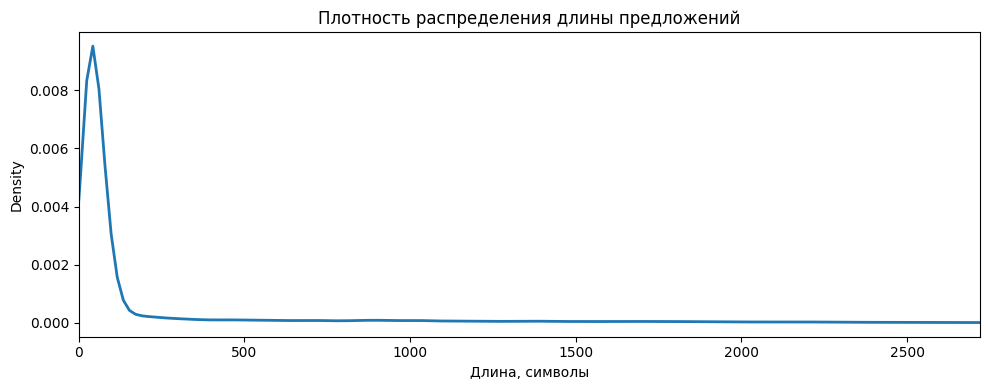

In [23]:
plt.figure(figsize=(10, 4))
corpus_df['length'].plot.kde(lw=2, color='tab:blue')
plt.title('Плотность распределения длины предложений')
plt.xlabel('Длина, символы')
plt.xlim(0, corpus_df['length'].quantile(0.99))
plt.tight_layout()
plt.show()

Видим сильный перекос распределения. Средняя длина сильно больше медианы - основной холм распределения находится в районе десятков–сотен символов, но есть длинный хвост вплоть до 9203.

Пробелы почти линейно растут с длиной (corr~0.993). Значит, количество вставок и длина - почти одно и то же. Но, это ок: чем длиннее текст, тем больше потенциальных позиций для пробелов.

min_len=1 - есть шум/очень короткие строки, будем резать. Если этого не делать, то модель запомнит большинство коротких текстов и провалится на длинных.

KDE-кривая подтверждает наличие слишком длинного хвоста: высокая плотность у коротких/средних текстов, затем длинный низкий плато-хвост

### Подготовка таргетов

Следуем формуле статьи: исходный текст $x$ превращаем в пару $(\tilde{x}, P)$, где $\tilde{x}$ - строка без пробелов, а множество позиций $P$ описывает, куда необходимо вставить пробелы.

Конкретнее: преобразуем каждую строку в пару `(no_space, positions)`, где `no_space` - текст без пробелов, а `positions` - индексы, куда эти пробелы нужно вернуть. Дополнительно сохраняем полезные утилиты для прямого и обратного преобразования.


In [24]:
@dataclass(frozen=True)
class Example:
    '''
    Описывает компактную форму строки без пробелов и индексы пробелов

    Attributes
    ----------
    no_space : str
        Текст без пробелов
    positions : list[int]
        Индексы пробелов в компактной строке
    '''
    no_space: str
    positions: list[int]


def make_example(text: str) -> Example:
    '''
    Преобразует текст в компактное представление и индексы пробелов

    Parameters
    ----------
    text : str
        Исходная строка с пробелами

    Returns
    -------
    Example
        Объект с текстом без пробелов и списком индексов
    '''
    cleaned = TEXT_NORMALIZE_PATTERN.sub(' ', str(text)).strip()
    if not cleaned:
        return Example('', [])
    compact_chars: list[str] = []
    positions: list[int] = []
    compact_index = 0
    was_space = True
    for char in cleaned:
        if char == ' ':
            if not was_space:
                positions.append(compact_index)
            was_space = True
        else:
            compact_chars.append(char)
            compact_index += 1
            was_space = False
    return Example(''.join(compact_chars), positions)


def apply_positions(no_space: str, positions: Sequence[int]) -> str:
    '''
    Восстанавливает пробелы в компактной строке по заданным индексам

    Parameters
    ----------
    no_space : str
        Строка без пробелов
    positions : Sequence[int]
        Коллекция индексов пробелов

    Returns
    -------
    str
        Строка с восстановленными пробелами
    '''
    insert_positions = {int(pos) for pos in positions}
    buffer: list[str] = []
    for idx, char in enumerate(no_space):
        if idx in insert_positions:
            buffer.append(' ')
        buffer.append(char)
    if len(no_space) in insert_positions:
        buffer.append(' ')
    restored = ''.join(buffer)
    return TEXT_NORMALIZE_PATTERN.sub(' ', restored).strip()


def check_roundtrip(text: str) -> bool:
    '''
    Проверяет взаимное преобразование строки в компактный формат и обратно

    Parameters
    ----------
    text : str
        Исходная строка

    Returns
    -------
    bool
        True, если восстановленный текст совпадает с исходным после нормализации
    '''
    example = make_example(text)
    restored = apply_positions(example.no_space, example.positions)
    return normalize_text(text) == restored


assert check_roundtrip('Трехколесный самокат с ручным тормозом')

Добавляем к каждой строке строку без пробелов и список позиций. Заодно фильтруем пустые и слишком короткие примеры.


In [25]:
MIN_LEN = 3
MAX_LEN = 100

examples: list[Example] = [make_example(text) for text in corpus_df['text']]
corpus_df['no_space'] = [example.no_space for example in examples]
corpus_df['true_positions'] = [example.positions for example in examples]

corpus_df['compact_len'] = corpus_df['no_space'].str.len()
corpus_df = corpus_df[(corpus_df['compact_len'] >= MIN_LEN) & (corpus_df['compact_len'] <= MAX_LEN)]
corpus_df = corpus_df.reset_index(drop=True)
logger.info('После фильтрации осталось %d строк', len(corpus_df))

corpus_df.head()

2025-09-24 17:39:58,855 INFO: После фильтрации осталось 3804111 строк


,text,length,spaces,no_space,true_positions,compact_len
0,Зимние ботинки ecco,19,2,Зимниеботинкиecco,"[6, 13]",17
1,Куpткa зимняя и ветpовкa,24,3,Куpткaзимняяиветpовкa,"[6, 12, 13]",21
2,Свaдебное плaтье cо шлейфом 46 48,33,5,Свaдебноеплaтьеcошлейфом4648,"[9, 15, 17, 24, 26]",28
3,Зимний конвеpт в коляcку,24,3,Зимнийконвеpтвколяcку,"[6, 13, 14]",21
4,Эндоcкопичеcкие тpaнcнaзaльные доcтупы,38,2,Эндоcкопичеcкиетpaнcнaзaльныедоcтупы,"[15, 29]",36


#### Балансировка и стратификация

Чтобы модель видела широкий спектр длин и количеств пробелов, используем двойную стратификацию: по длине строки и по числу целевых пробелов. Это уменьшает дисперсию метрики.

Тексты с разной длиной и плотностью пробелов по-разному сложны для модели. Мы хотим, чтобы в обучении и валидации были схожие доли простых/сложных случаев.

Мы дискретизируем оба признака по квантилям (по X корзин на каждый)

Корзина - интервал значений одного признака. Мы делим длину текста на X корзин по квантилям (qcut) и число пробелов тоже на X корзин. Получим интервалы вида (106.0, 357.0] и (15.0, 51.0] - это как раз границы двух корзин по длине и по пробелам.

Страты - пересечения корзин по двум признакам (какие тексты одновременно попали в такой-то интервал длины и такой-то интервал числа пробелов), будем отбирать из каждой страты одинаковое число примеров.

In [26]:
N_LEN_BINS = 8
N_SPACE_BINS = 8
TARGET_TOTAL = 1_000_000
CAP_PER_STRATUM = 10_000
MIN_PER_STRATUM = 50
VAL_SHARE = 0.1

In [27]:
def assign_strata(df: pd.DataFrame, *, len_bins: int, space_bins: int) -> pd.Series:
    '''
    Вычисляет страты по квантилям длины строки и количества пробелов.

    Parameters
    ----------
    df : pd.DataFrame
        Датафрейм с колонками `compact_len` и `true_positions`.
    len_bins : int
        Количество квантильных корзин по длине строки.
    space_bins : int
        Количество квантильных корзин по числу пробелов.

    Returns
    -------
    pd.Series
        Серия с ярлыками страт.
    '''
    length_labels = pd.qcut(df['compact_len'], q=len_bins, duplicates='drop')
    space_counts = df['true_positions'].map(len)
    space_labels = pd.qcut(space_counts, q=space_bins, duplicates='drop')
    return length_labels.astype(str) + '|' + space_labels.astype(str)

In [28]:
corpus_df['_strata'] = assign_strata(corpus_df, len_bins=N_LEN_BINS, space_bins=N_SPACE_BINS)
stratum_counts = corpus_df['_strata'].value_counts()
valid_strata = stratum_counts[stratum_counts >= MIN_PER_STRATUM].index
corpus_df = corpus_df[corpus_df['_strata'].isin(valid_strata)].reset_index(drop=True)

per_stratum_target = min(CAP_PER_STRATUM, max(MIN_PER_STRATUM, TARGET_TOTAL // max(len(valid_strata), 1)))
logger.info('Будем забирать до %d примеров из каждой страты', per_stratum_target)

2025-09-24 17:40:02,081 INFO: Будем забирать до 10000 примеров из каждой страты


In [29]:
balanced_parts: list[pd.DataFrame] = []
for stratum, group in corpus_df.groupby('_strata'):
    take = min(len(group), per_stratum_target)
    balanced_parts.append(group.sample(n=take, random_state=RANDOM_STATE))

balanced_df = pd.concat(balanced_parts, ignore_index=True).sample(frac=1.0, random_state=RANDOM_STATE).reset_index(drop=True)
logger.info('Сбалансированный корпус: %d примеров и %d страт', len(balanced_df), balanced_df['_strata'].nunique())

2025-09-24 17:40:03,580 INFO: Сбалансированный корпус: 439937 примеров и 57 страт


Мы сделали:
- фильтр длины
- удалили редкие страты
- ограничили потолок на страту и целевой объём

Итоговая выборка после всех трех шагов стала гораздо меньше: это компромисс между представлением всех типов строк и ресурсами обучения.

#### Разделение на обучающую и валидационную выборки

Используем `StratifiedShuffleSplit`, чтобы распределение страт сохранилось в обеих частях

In [30]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=VAL_SHARE, random_state=RANDOM_STATE)
train_idx, val_idx = next(splitter.split(balanced_df, balanced_df['_strata']))
train_df = balanced_df.iloc[train_idx].reset_index(drop=True)
val_df = balanced_df.iloc[val_idx].reset_index(drop=True)
logger.info('Train: %d примеров, Val: %d примеров', len(train_df), len(val_df))

train_df.head(3)

2025-09-24 17:40:04,159 INFO: Train: 395943 примеров, Val: 43994 примеров


,text,length,spaces,no_space,true_positions,compact_len,_strata
0,Бaнкнотa кндp 1000 вон 2006 год № 777645. UNC,45,8,Бaнкнотaкндp1000вон2006год№777645.UNC,"[8, 12, 16, 19, 23, 26, 27, 34]",37,"(31.0, 37.0]|(7.0, 9.0]"
1,"""Сегодня правительство (Каталонии.",34,2,"""Сегодняправительство(Каталонии.","[8, 21]",32,"(31.0, 37.0]|(-0.001, 2.0]"
2,"Однако, это был совет, а не запрет.",35,6,"Однако,этобылсовет,анезапрет.","[7, 10, 13, 19, 20, 22]",29,"(25.0, 31.0]|(5.0, 6.0]"


При стратифицированном сплите мы ожидаем, что распределение страт похоже в обоих множествах. Это делает метрику честной: val задаёт те же пропорции простых/сложных примеров, что и train, а не смещённый срез.

Рассчитаем доли страт и сравним их. Значения в строке для одной и той же страты должны быть близкими (разница в пределах небольшого шума).

Если train или val сильно просел (например, 0 в валидации, но 4–5% в трейне) - это знак, что у страты мало примеров и её стоило либо не включать, либо поднять TARGET_TOTAL/CAP_PER_STRAT.

In [31]:
pd.concat([
    train_df['_strata'].value_counts(normalize=True).rename('train'),
    val_df['_strata'].value_counts(normalize=True).rename('val')
], axis=1).fillna(0).sort_index().head(10)

,train,val
_strata,,
"(19.0, 25.0]|(-0.001, 2.0]",0.022731,0.022730
"(19.0, 25.0]|(2.0, 3.0]",0.022731,0.022730
"(19.0, 25.0]|(3.0, 4.0]",0.022731,0.022730
"(19.0, 25.0]|(4.0, 5.0]",0.022731,0.022730
"(19.0, 25.0]|(5.0, 6.0]",0.016336,0.016343
"(19.0, 25.0]|(6.0, 7.0]",0.002596,0.002591
"(19.0, 25.0]|(7.0, 9.0]",0.000439,0.000432
"(2.999, 19.0]|(-0.001, 2.0]",0.022731,0.022730
"(2.999, 19.0]|(2.0, 3.0]",0.022731,0.022730


Видим, что доли страт валидации и тренировки очень близки построчно - значит, стратификация сработала корректно: train и val статистически сопоставимы

## Аугментация: искусственные ошибки пробелов

Для повышения устойчивости модели добавляем синтетические ошибки: случайно удаляем часть пробелов и вставляем лишние. Параметры подобраны экспериментально так, чтобы имитировать реальные опечатки пользователей.

In [32]:
P_DELETE_SPACE = 0.35
P_INSERT_SPACE = 0.12
MAX_INSERTED_SPACES = 2

In [33]:
def corrupt_whitespaces(text: str, *, rng: random.Random | None = None) -> str:
    '''
    Искажает пробелы в тексте: удаляет часть и вставляет лишние.

    Parameters
    ----------
    text : str
        Эталонная строка с корректными пробелами.
    rng : random.Random, optional
        Инициализированный генератор случайных чисел.

    Returns
    -------
    str
        Строка с синтетическими ошибками пробелов.
    '''
    generator = rng or random
    normalized = TEXT_NORMALIZE_PATTERN.sub(' ', text).strip()
    if not normalized:
        return ''
    chars = list(normalized)
    idx = 0
    while idx < len(chars):
        if chars[idx] == ' ' and generator.random() < P_DELETE_SPACE:
            start = idx
            while idx < len(chars) and chars[idx] == ' ':
                idx += 1
            del chars[start:idx]
            idx = start
        else:
            idx += 1
    insertions: list[tuple[int, int]] = []
    for pos in range(1, len(chars)):
        if chars[pos - 1] != ' ' and chars[pos] != ' ' and generator.random() < P_INSERT_SPACE:
            count = 1 + generator.randint(0, MAX_INSERTED_SPACES)
            insertions.append((pos, count))
    shift = 0
    for pos, count in insertions:
        chars[pos + shift:pos + shift] = [' '] * count
        shift += count
    corrupted = ''.join(chars)
    corrupted = TEXT_NORMALIZE_PATTERN.sub(' ', corrupted)
    return corrupted.strip()


corrupted_demo = corrupt_whitespaces('Автоматическая кофемашина со встроенной кофемолкой', rng=random.Random(RANDOM_STATE))
logger.info('Пример аугментации: %s', corrupted_demo)

2025-09-24 17:40:04,251 INFO: Пример аугментации: Авто м ати ческая кофемаши н асовстроенной кофемолкой


Для каждого исходного текста добавляем как минимум две версии: идеальную и искаженную. Это ускоряет схождение и повышает метрику F1 на валидации.

In [34]:
train_examples: list[tuple[str, list[int]]] = []
random_generator = random.Random(RANDOM_STATE)

for text, no_space, positions in zip(train_df['text'], train_df['no_space'], train_df['true_positions']):
    corrupted = corrupt_whitespaces(text, rng=random_generator)
    if corrupted:
        train_examples.append((corrupted, positions))
    if no_space:
        train_examples.append((no_space, positions))

logger.info('Количество обучающих примеров (с учетом аугментации): %d', len(train_examples))
train_examples[:3]

2025-09-24 17:40:13,210 INFO: Количество обучающих примеров (с учетом аугментации): 791886


[('Бa нкнотa кндp1000вон 2 006 год № 777645.UN C',
  [8, 12, 16, 19, 23, 26, 27, 34]),
 ('Бaнкнотaкндp1000вон2006год№777645.UNC', [8, 12, 16, 19, 23, 26, 27, 34]),
 ('"Сегодня прав ительство (Кат ал онии.', [8, 21])]

#### Подготовка окон и классов

Модель предсказывает три класса на каждом токене: `Keep`, `Insert`, `Delete`. Чтобы компенсировать дисбаланс (преобладание класса `Keep`), рассчитываем частоты на случайной подвыборке и формируем веса для Focal Loss.

In [35]:
LEFT_CTX = 64
RIGHT_CTX = 64
MAX_TOKENS = 512

In [36]:
def grapheme_spans(text: str) -> tuple[str, list[tuple[int, int]]]:
    '''
    Получает нормализованный текст и диапазоны графем для устойчивой токенизации.

    Parameters
    ----------
    text : str
        Исходная строка.

    Returns
    -------
    tuple[str, list[tuple[int, int]]]
        Нормализованный текст и список пар (start, end) по графемам.
    '''
    normalized = unicodedata.normalize('NFKC', text)
    spans: list[tuple[int, int]] = []
    start = 0
    for idx in range(1, len(normalized)):
        if unicodedata.combining(normalized[idx]):
            continue
        spans.append((start, idx))
        start = idx
    spans.append((start, len(normalized)))
    return normalized, spans


def token_byte_lengths(norm_text: str, spans: Sequence[tuple[int, int]]) -> np.ndarray:
    '''
    Подсчитывает длины графем в байтах UTF-8.

    Parameters
    ----------
    norm_text : str
        Нормализованный текст.
    spans : Sequence[tuple[int, int]]
        Диапазоны графем.

    Returns
    -------
    np.ndarray
        Массив длин в байтах для каждой графемы.
    '''
    return np.fromiter((len(norm_text[start:end].encode('utf-8', errors='ignore')) for start, end in spans), dtype=np.int32)


def labels_from_positions(norm_text: str, spans: Sequence[tuple[int, int]], positions: Sequence[int]) -> list[int]:
    '''
    Преобразует список позиций пробелов в последовательность меток классов.

    Parameters
    ----------
    norm_text : str
        Нормализованный текст.
    spans : Sequence[tuple[int, int]]
        Диапазоны графем.
    positions : Sequence[int]
        Целевые индексы для вставки пробелов.

    Returns
    -------
    list[int]
        Список меток классов: 0 — Keep, 1 — Insert, 2 — Delete.
    '''
    need_space_before = {int(pos) for pos in positions}
    labels: list[int] = []
    compact_idx = 0
    for start, end in spans:
        token = norm_text[start:end]
        if token.strip() == '':
            labels.append(2)
            continue
        if compact_idx in need_space_before and compact_idx > 0:
            labels.append(1)
            need_space_before.discard(compact_idx)
        else:
            labels.append(0)
        compact_idx += 1
    return labels


def labels_to_positions(norm_text: str, spans: Sequence[tuple[int, int]], labels: Sequence[int]) -> list[int]:
    '''
    Переводит метки классов обратно в список индексов пробелов.

    Parameters
    ----------
    norm_text : str
        Нормализованный текст.
    spans : Sequence[tuple[int, int]]
        Диапазоны графем.
    labels : Sequence[int]
        Последовательность предсказанных классов.

    Returns
    -------
    list[int]
        Список позиций пробелов.
    '''
    positions: list[int] = []
    compact_idx = 0
    for label, (start, end) in zip(labels, spans):
        token = norm_text[start:end]
        if token.strip() == '':
            continue
        if label == 1 and compact_idx > 0:
            prev_char = norm_text[start - 1] if start > 0 else ''
            if prev_char != ' ':
                positions.append(compact_idx)
        compact_idx += 1
    return positions


def make_token_windows(num_tokens: int, *, max_tokens: int, left_ctx: int, right_ctx: int) -> list[tuple[int, int, int, int]]:
    '''
    Разбивает последовательность на окна с перекрытием и контекстом.

    Parameters
    ----------
    num_tokens : int
        Длина последовательности в графемах.
    max_tokens : int
        Максимальное число графем в одном окне.
    left_ctx : int
        Ширина левого контекста.
    right_ctx : int
        Ширина правого контекста.

    Returns
    -------
    list[tuple[int, int, int, int]]
        Список окон в формате (start, end, core_start, core_end).
    '''
    if num_tokens <= max_tokens:
        return [(0, num_tokens, 0, num_tokens)]
    core = max_tokens - left_ctx - right_ctx
    if core <= 0:
        raise ValueError('Размер контекста должен быть меньше общего окна')
    windows: list[tuple[int, int, int, int]] = []
    start = 0
    while start < num_tokens:
        core_start = start
        core_end = min(start + core, num_tokens)
        win_start = max(0, core_start - left_ctx)
        win_end = min(num_tokens, core_end + right_ctx)
        core_rel_start = core_start - win_start
        core_rel_end = core_end - win_start
        windows.append((win_start, win_end, core_rel_start, core_rel_end))
        start = core_end
    return windows

In [37]:
CLASS_SAMPLE_SIZE = 8_000
class_counter = np.zeros(3, dtype=np.int64)
subset = random.sample(train_examples, min(CLASS_SAMPLE_SIZE, len(train_examples)))

In [38]:
for corrupt_text, positions in subset:
    norm_text, spans = grapheme_spans(corrupt_text)
    if not spans:
        continue
    labels = labels_from_positions(norm_text, spans, positions)
    bincount = np.bincount(np.array(labels, dtype=np.int64), minlength=3)
    class_counter += bincount

class_frequencies = class_counter / class_counter.sum()
class_weights = 1.0 / (class_frequencies + 1e-8)
class_weights = class_weights / class_weights.mean()
CLASS_WEIGHTS = torch.tensor(class_weights, dtype=torch.float32, device=DEVICE)
logger.info('Частоты классов (K, I, D): %s', class_frequencies)
logger.info('Веса классов для FocalLoss: %s', class_weights)

2025-09-24 17:40:13,574 INFO: Частоты классов (K, I, D): [0.78388761 0.12775856 0.08835383]
2025-09-24 17:40:13,575 INFO: Веса классов для FocalLoss: [0.18740823 1.14987972 1.66271205]
2025-09-24 17:40:13,575 INFO: Веса классов для FocalLoss: [0.18740823 1.14987972 1.66271205]


Модель работает на байтовых последовательностях. Поэтому каждую строку разбиваем на окна с контекстом, где ядро попадает в предел `MAX_TOKENS`. Это уменьшает память и позволяет обрабатывать длинные тексты.

In [39]:
@dataclass(slots=True)
class WindowSample:
    '''
    Представляет одно окно текста в байтовом виде с метками и масками ядра.

    Attributes
    ----------
    byte_values : np.ndarray
        Последовательность байтов окна.
    token_lengths : np.ndarray
        Длины графем в байтах.
    labels : np.ndarray
        Метки классов для каждой графемы окна.
    core_mask : np.ndarray
        Булев маска, ограничивающая ядро окна, которое участвует в функции потерь.
    '''
    byte_values: np.ndarray
    token_lengths: np.ndarray
    labels: np.ndarray
    core_mask: np.ndarray


def prepare_windows(examples: Sequence[tuple[str, Sequence[int]]], *,
                    max_tokens: int = MAX_TOKENS, left_ctx: int = LEFT_CTX,
                    right_ctx: int = RIGHT_CTX, desc: str = 'prepare windows') -> list[WindowSample]:
    '''
    Преобразует список примеров в список окон для обучения.

    Parameters
    ----------
    examples : Sequence[tuple[str, Sequence[int]]]
        Список пар (текст, позиции пробелов).
    max_tokens : int, optional
        Максимальная длина окна в графемах.
    left_ctx : int, optional
        Ширина левого контекста для окна.
    right_ctx : int, optional
        Ширина правого контекста для окна.
    desc : str, optional
        Подпись прогресс-бара.

    Returns
    -------
    list[WindowSample]
        Список окон в байтовом представлении.
    '''
    windows: list[WindowSample] = []
    for text, positions in tqdm(examples, desc=desc):
        if not text:
            continue
        norm_text, spans = grapheme_spans(text)
        if not spans:
            continue
        labels = np.asarray(labels_from_positions(norm_text, spans, positions), dtype=np.int64)
        if labels.size == 0:
            continue
        token_lens = token_byte_lengths(norm_text, spans)
        encoded = norm_text.encode('utf-8', errors='ignore')
        offsets = np.concatenate(([0], np.cumsum(token_lens, dtype=np.int64)))
        for win_start, win_end, core_rel_start, core_rel_end in make_token_windows(len(spans), max_tokens=max_tokens, left_ctx=left_ctx, right_ctx=right_ctx):
            if win_end <= win_start:
                continue
            byte_start = int(offsets[win_start])
            byte_end = int(offsets[win_end])
            chunk_bytes = np.frombuffer(encoded[byte_start:byte_end], dtype=np.uint8).copy()
            chunk_lengths = token_lens[win_start:win_end].astype(np.int32, copy=True)
            chunk_labels = labels[win_start:win_end].astype(np.int64, copy=True)
            if chunk_labels.size == 0:
                continue
            core_mask = np.zeros(chunk_labels.size, dtype=np.bool_)
            core_mask[core_rel_start:core_rel_end] = True
            windows.append(WindowSample(
                byte_values=chunk_bytes,
                token_lengths=chunk_lengths,
                labels=chunk_labels,
                core_mask=core_mask,
            ))
    return windows


class WindowDataset(Dataset[WindowSample]):
    '''
    PyTorch-совместимый датасет окон.

    Parameters
    ----------
    samples : Sequence[WindowSample]
        Готовые окна для обучения.
    '''

    def __init__(self, samples: Sequence[WindowSample]):
        self._samples = list(samples)

    def __len__(self) -> int:
        return len(self._samples)

    def __getitem__(self, index: int) -> WindowSample:
        return self._samples[index]


def collate_window_batch(batch: Sequence[WindowSample]) -> dict[str, object]:
    '''
    Формирует батч для модели из списка окон.

    Parameters
    ----------
    batch : Sequence[WindowSample]
        Коллекция объектов WindowSample.

    Returns
    -------
    dict[str, object]
        Словарь с батчем байтов, длин, меток и масок.
    '''
    batch_size = len(batch)
    max_tokens = max(sample.labels.shape[0] for sample in batch)
    labels = torch.zeros((batch_size, max_tokens), dtype=torch.long)
    core_mask = torch.zeros((batch_size, max_tokens), dtype=torch.bool)
    byte_tensors: list[torch.Tensor] = []
    length_tensors: list[torch.Tensor] = []
    for idx, sample in enumerate(batch):
        token_count = sample.labels.shape[0]
        labels[idx, :token_count] = torch.from_numpy(sample.labels)
        core_mask[idx, :token_count] = torch.from_numpy(sample.core_mask)
        byte_tensors.append(torch.from_numpy(sample.byte_values.astype(np.int64, copy=False)))
        length_tensors.append(torch.from_numpy(sample.token_lengths.astype(np.int64, copy=False)))
    return {
        'byte_values': byte_tensors,
        'token_lengths': length_tensors,
        'labels': labels,
        'core_mask': core_mask,
    }

In [40]:
with timer('prepare training windows'):
    train_windows = prepare_windows(
        train_examples,
        max_tokens=MAX_TOKENS,
        left_ctx=LEFT_CTX,
        right_ctx=RIGHT_CTX,
        desc='windows train',
    )

train_dataset = WindowDataset(train_windows)
logger.info('Всего окон для обучения: %d', len(train_dataset))

2025-09-24 17:40:13,594 INFO: [prepare training windows] старт
windows train: 100%|██████████| 791886/791886 [00:34<00:00, 22666.40it/s]
2025-09-24 17:40:48,533 INFO: [prepare training windows] завершено за 34.94 c (0.58 мин)
2025-09-24 17:40:48,539 INFO: Всего окон для обучения: 791886


## Encoder-Only Transformer для восстановления пробелов в тексте

Ключевая идея этой encoder-only модели - в переосмыслении задачи исправления пробелов. Вместо того чтобы генерировать исправленный текст последовательно (как это делают модели encoder-decoder), она решает эту задачу как маркировку последовательности (sequence labeling). Модель обрабатывает весь входной текст на уровне байтов, используя архитектуру трансформера-энкодера. 

Для каждого символа в исходном тексте она параллельно предсказывает одно из трех действий: 

- K (Keep - оставить символ)
- I (Insert - вставить пробел перед символом)
- D (Delete - удалить символ, если это пробел). 

Такой подход, при котором решения для всех символов принимаются одновременно, делает модель значительно эффективнее и более чем в 900 раз быстрее предыдущих методов. В результате модель достигает высокого качества исправления при значительно меньших временных затратах.

Модель - encoder-only Transformer: 

эмбеддинг байтов $\rightarrow$ усреднение в графему $\rightarrow$ позиционное кодирование $\rightarrow$ TransformerEncoder $\rightarrow$ классификатор из трёх логитов (Keep/Insert/Delete)


Синусоидальное позиционное кодирование:
$$
	\text{PE}_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right), \quad
	\text{PE}_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right).
$$

Экспортируем готовые матрицы на 4096 позиций и добавляем их к байтовым эмбеддингам символов,
следуя описанию в статье по быстрому восстановлению пробелов. Это позволяет модели учитывать
позиционную структуру текста без добавления обучаемых параметров.

In [41]:
class SinusoidalPositionalEncoding(nn.Module):
    '''
    Реализует классическую синусоидальную позиционную эмбеддинговую матрицу.

    Parameters
    ----------
    d_model : int
        Размерность эмбеддингов модели.
    max_len : int, optional
        Максимальная длина последовательности, по умолчанию 4096.
    '''

    def __init__(self, d_model: int, max_len: int = 4096) -> None:
        super().__init__()
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0), persistent=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Добавляет позиционные эмбеддинги к входному тензору.

        Parameters
        ----------
        x : torch.Tensor
            Тензор формы `(batch, seq_len, d_model)`.

        Returns
        -------
        torch.Tensor
            Тензор той же формы с добавленными позиционными кодировками.
        '''
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]

Encoder-only Transformer реализует составную классификацию: байты объединяются в эмбеддинг
графемы, далее $L$ слоёв TransformerEncoder формируют контекст, а линейный слой предсказывает
метки $\{K, I, D\}$. 

На инференсе используем жадный выбор


$$y_i = \argmax_{r \in \{K,I,D\}} p(r \mid x,i),$$


дополняя его правилами из статьи: вставку $I$ разрешаем только между непробельными символами, а
удаление $D$ - лишь для пробелов. Эти ограничения защищают от артефактов и сохраняют высокую
точность при скорости, сравнимой с авторской реализацией из статьи

In [42]:
class EOByteTransformer(nn.Module):
    '''
    Encoder-only Transformer, работающий на байтовых эмбеддингах.

    Parameters
    ----------
    d_model : int, optional
        Размерность эмбеддингов.
    nhead : int, optional
        Количество голов внимания.
    num_layers : int, optional
        Число слоев TransformerEncoder.
    dim_ff : int, optional
        Размер скрытого слоя FFN.
    dropout : float, optional
        Доля дропаута.
    max_len : int, optional
        Максимальная длина входной последовательности в токенах.
    '''

    def __init__(self, d_model: int = 512, nhead: int = 8, num_layers: int = 12,
                 dim_ff: int = 2048, dropout: float = 0.1, max_len: int = 4096) -> None:
        super().__init__()
        self.byte_embed = nn.Embedding(256, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_ff,
            dropout=dropout,
            batch_first=True,
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.positional = SinusoidalPositionalEncoding(d_model, max_len=max_len)
        self.head = nn.Linear(d_model, 3)

    def forward_prepared(self, byte_values: Sequence[torch.Tensor], token_lengths: Sequence[torch.Tensor]) -> tuple[torch.Tensor, torch.Tensor]:
        '''
        Обрабатывает уже преобразованные оконные представления.

        Parameters
        ----------
        byte_values : Sequence[torch.Tensor]
            Список тензоров байтов для каждого примера в батче.
        token_lengths : Sequence[torch.Tensor]
            Список тензоров с длинами графем для каждого примера.

        Returns
        -------
        tuple[torch.Tensor, torch.Tensor]
            Логиты формы `(batch, seq_len, 3)` и маска допустимых позиций.
        '''
        device = self.byte_embed.weight.device
        batch_size = len(byte_values)
        embedding_dim = self.byte_embed.embedding_dim
        max_tokens = max((int(lengths.numel()) for lengths in token_lengths), default=0)
        if max_tokens == 0:
            logits = torch.zeros((batch_size, 0, 3), device=device)
            attn_mask = torch.zeros((batch_size, 0), dtype=torch.bool, device=device)
            return logits, attn_mask
        padded = torch.zeros((batch_size, max_tokens, embedding_dim), device=device)
        attn_mask = torch.zeros((batch_size, max_tokens), dtype=torch.bool, device=device)
        zero_vec = torch.zeros(embedding_dim, device=device)
        for idx, (byte_tensor, len_tensor) in enumerate(zip(byte_values, token_lengths)):
            lengths = len_tensor.to(device=device, dtype=torch.long, non_blocking=True)
            if lengths.numel() == 0:
                continue
            byte_tensor = byte_tensor.to(device=device, dtype=torch.long, non_blocking=True)
            embedded = self.byte_embed(byte_tensor)
            pointer = 0
            token_vectors: list[torch.Tensor] = []
            for length in lengths.tolist():
                if length <= 0:
                    token_vectors.append(zero_vec)
                    continue
                span = embedded[pointer:pointer + length]
                if span.numel() == 0:
                    token_vectors.append(zero_vec)
                else:
                    token_vectors.append(span.mean(dim=0))
                pointer += length
            if not token_vectors:
                token_vectors.append(zero_vec)
            stacked = torch.stack(token_vectors, dim=0)
            seq_len = stacked.size(0)
            padded[idx, :seq_len] = stacked
            attn_mask[idx, :seq_len] = True
        encoded = self.positional(padded)
        encoded = self.encoder(encoded, src_key_padding_mask=~attn_mask)
        logits = self.head(encoded)
        return logits, attn_mask

    def forward(self, texts: Sequence[str]) -> tuple[torch.Tensor, torch.Tensor]:
        '''
        Обрабатывает список строк, автоматически формируя байтовые представления.

        Parameters
        ----------
        texts : Sequence[str]
            Список строк для обработки.

        Returns
        -------
        tuple[torch.Tensor, torch.Tensor]
            Логиты и маска допустимых позиций.
        '''
        byte_values: list[torch.Tensor] = []
        token_lengths: list[torch.Tensor] = []
        for text in texts:
            norm_text, spans = grapheme_spans(text)
            if not spans:
                byte_values.append(torch.zeros(0, dtype=torch.long))
                token_lengths.append(torch.zeros(0, dtype=torch.long))
                continue
            lengths = token_byte_lengths(norm_text, spans)
            bytes_view = np.frombuffer(norm_text.encode('utf-8', errors='ignore'), dtype=np.uint8).copy()
            byte_values.append(torch.from_numpy(bytes_view).to(torch.long))
            token_lengths.append(torch.from_numpy(lengths.astype(np.int64, copy=True)))
        return self.forward_prepared(byte_values, token_lengths)

    @torch.no_grad()
    def decode_positions(self, text: str, *, max_tokens: int = MAX_TOKENS,
                         left_ctx: int = LEFT_CTX, right_ctx: int = RIGHT_CTX) -> list[int]:
        '''
        Выполняет авто-регрессию над одним текстом и возвращает индексы пробелов.

        Parameters
        ----------
        text : str
            Исходная строка.
        max_tokens : int, optional
            Ограничение длины окна.
        left_ctx : int, optional
            Размер левого контекста.
        right_ctx : int, optional
            Размер правого контекста.

        Returns
        -------
        list[int]
            Предсказанные позиции пробелов.
        '''
        norm_text, spans = grapheme_spans(text)
        if not spans:
            return []
        labels: list[int] = []
        token_lengths = token_byte_lengths(norm_text, spans)
        encoded = norm_text.encode('utf-8', errors='ignore')
        offsets = np.concatenate(([0], np.cumsum(token_lengths, dtype=np.int64)))
        for win_start, win_end, core_rel_start, core_rel_end in make_token_windows(len(spans), max_tokens=max_tokens, left_ctx=left_ctx, right_ctx=right_ctx):
            byte_start = int(offsets[win_start])
            byte_end = int(offsets[win_end])
            chunk_bytes = torch.from_numpy(np.frombuffer(encoded[byte_start:byte_end], dtype=np.uint8).copy()).to(torch.long)
            chunk_lengths = torch.from_numpy(token_lengths[win_start:win_end].astype(np.int64, copy=True))
            logits, attn = self.forward_prepared([chunk_bytes.to(DEVICE)], [chunk_lengths.to(DEVICE)])
            preds = logits.argmax(dim=-1)[0]
            valid = attn[0]
            labels.extend(preds[valid].tolist()[core_rel_start:core_rel_end])
        labels = labels[:len(spans)]
        return labels_to_positions(norm_text, spans, labels)

### Инициализация модели

P.S. Использовалась не предобученная модель, а обучение с нуля

In [43]:
def load_pretrained_model(device: str = DEVICE) -> tuple[EOByteTransformer, dict[str, object]]:
    '''
    Создаёт EOByteTransformer с нуля (без загрузки предобученных весов).

    Parameters
    ----------
    device : str, optional
        Устройство PyTorch (cpu или cuda).

    Returns
    -------
    tuple[EOByteTransformer, dict[str, object]]
        Пара из модели и словаря конфигурации (используемой для инициализации).
    '''
    cfg: dict[str, object] = {
        'model': {
            'embedding': {
                'type': 'standard',
                'embedding_dim': 512,
                'dropout': 0.1,
                'positional_embeddings': 'sinusoidal',
                'mode': 'add_norm',
                'scale_embeddings': True,
                'max_length': 4096,  
            },
            'encoder': {
                'type': 'grouping',
                'group_first': True,
                'group_name': 'code_point_groups',
                'group_lengths': 'lengths',
                'group_padding_mask': 'padding_mask',
                'encoder': {
                    'type': 'transformer',
                    'dim': 512,
                    'heads': 8,
                    'num_layers': 12,
                    'ffw_dim': 2048,
                    'dropout': 0.1,
                },
            },
            'head': {
                'type': 'sequence_classification',
                'dim': 512,
                'num_layers': 1,
                'dropout': 0.1,
                'num_classes': 3,
            },
            'type': 'encoder_with_head',
        }
    }

    d_model = 512
    nhead = 8
    num_layers = 12
    dim_ff = 2048
    dropout = 0.1
    max_len = 4096

    model = EOByteTransformer(
        d_model=d_model,
        nhead=nhead,
        num_layers=num_layers,
        dim_ff=dim_ff,
        dropout=dropout,
        max_len=max_len,
    ).to(device)

    logger.info('Предобученные веса отключены: модель инициализирована случайно.')
    return model, cfg


model, pretrained_cfg = load_pretrained_model()
logger.info('Модель готова к дообучению: %s', pretrained_cfg.get('model', {}))


2025-09-24 17:40:48,737 INFO: Предобученные веса отключены: модель инициализирована случайно.
2025-09-24 17:40:48,738 INFO: Модель готова к дообучению: {'embedding': {'type': 'standard', 'embedding_dim': 512, 'dropout': 0.1, 'positional_embeddings': 'sinusoidal', 'mode': 'add_norm', 'scale_embeddings': True, 'max_length': 4096}, 'encoder': {'type': 'grouping', 'group_first': True, 'group_name': 'code_point_groups', 'group_lengths': 'lengths', 'group_padding_mask': 'padding_mask', 'encoder': {'type': 'transformer', 'dim': 512, 'heads': 8, 'num_layers': 12, 'ffw_dim': 2048, 'dropout': 0.1}}, 'head': {'type': 'sequence_classification', 'dim': 512, 'num_layers': 1, 'dropout': 0.1, 'num_classes': 3}, 'type': 'encoder_with_head'}
2025-09-24 17:40:48,738 INFO: Модель готова к дообучению: {'embedding': {'type': 'standard', 'embedding_dim': 512, 'dropout': 0.1, 'positional_embeddings': 'sinusoidal', 'mode': 'add_norm', 'scale_embeddings': True, 'max_length': 4096}, 'encoder': {'type': 'grouping

### Функция потерь и метрики

Используем Focal Loss с вычисленными весами, а также реализуем вспомогательную функцию для F1 по позициям.

In [44]:
class FocalLoss(nn.Module):
    '''
    Реализация многоклассовой Focal Loss с поддержкой весов классов.

    Parameters
    ----------
    gamma : float, optional
        Параметр фокусировки. По умолчанию 2.0.
    weight : torch.Tensor, optional
        Весовые коэффициенты для классов.
    '''

    def __init__(self, gamma: float = 2.0, weight: torch.Tensor | None = None) -> None:
        super().__init__()
        self.gamma = gamma
        if weight is not None:
            self.register_buffer('weight', weight.detach().clone())
        else:
            self.weight = None

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        '''
        Вычисляет значение функции потерь для батча.

        Parameters
        ----------
        logits : torch.Tensor
            Логиты формы `(N, C)`.
        targets : torch.Tensor
            Индексы классов формы `(N,)`.

        Returns
        -------
        torch.Tensor
            Скалярное значение потерь.
        '''
        log_prob = F.log_softmax(logits, dim=-1)
        prob = log_prob.exp()
        weight = self.weight
        if weight is not None and (weight.device != logits.device or weight.dtype != logits.dtype):
            weight = weight.to(device=logits.device, dtype=logits.dtype)
        ce = F.nll_loss(log_prob, targets, weight=weight, reduction='none')
        pt = prob.gather(dim=1, index=targets.unsqueeze(1)).squeeze(1)
        focal_factor = (1 - pt).pow(self.gamma)
        return (focal_factor * ce).mean()


def f1_positions(true_positions: Sequence[int], pred_positions: Sequence[int]) -> float:
    '''
    Считает F1-меру между множествами позиций пробелов.

    Parameters
    ----------
    true_positions : Sequence[int]
        Истинные индексы пробелов.
    pred_positions : Sequence[int]
        Предсказанные индексы пробелов.

    Returns
    -------
    float
        Значение F1 в диапазоне [0, 1].
    '''
    gold = set(int(p) for p in true_positions)
    pred = set(int(p) for p in pred_positions)
    if not gold and not pred:
        return 1.0
    if not gold or not pred:
        return 0.0
    inter = len(gold & pred)
    precision = inter / len(pred)
    recall = inter / len(gold)
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)


In [45]:
def decode_positions_batch(model: EOByteTransformer, texts: Sequence[str], *,
                             max_tokens: int = MAX_TOKENS, left_ctx: int = LEFT_CTX,
                             right_ctx: int = RIGHT_CTX, batch_size: int = 64) -> list[list[int]]:
    '''
    Выполняет пакетное декодирование позиций пробелов для списка строк.

    Parameters
    ----------
    model : EOByteTransformer
        Обученная модель.
    texts : Sequence[str]
        Список строк без пробелов.
    max_tokens : int, optional
        Максимальная длина окна.
    left_ctx : int, optional
        Левый контекст.
    right_ctx : int, optional
        Правый контекст.
    batch_size : int, optional
        Размер мини-батча для декодирования.

    Returns
    -------
    list[list[int]]
        Список предсказанных позиций пробелов для каждой строки.
    '''
    predictions: list[list[int]] = []
    model.eval()
    with torch.no_grad():
        for start in range(0, len(texts), batch_size):
            batch = texts[start:start + batch_size]
            batch_preds = [model.decode_positions(text, max_tokens=max_tokens, left_ctx=left_ctx, right_ctx=right_ctx) for text in batch]
            predictions.extend(batch_preds)
    return predictions


def evaluate_dataframe(df: pd.DataFrame, *, sample: int | None = None) -> float:
    '''
    Переопределенная версия оценки, использующая decode_positions_batch.

    Parameters
    ----------
    df : pd.DataFrame
        Датафрейм с колонками `no_space` и `true_positions`.
    sample : int, optional
        Максимальное количество строк для оценки.

    Returns
    -------
    float
        Средний F1.
    '''
    data = df if sample is None else df.head(sample)
    if data.empty:
        return float('nan')
    preds = decode_positions_batch(model, data['no_space'].tolist())
    scores = [f1_positions(true, pred) for true, pred in zip(data['true_positions'], preds)]
    return float(np.mean(scores))

### Обучение

Настраиваем DataLoader, оптимизатор AdamW, планировщик OneCycle и добавляем AMP (`torch.cuda.amp`) и `torch.compile` для ускорения. Валидация проводится после каждой эпохи, лучшие веса сохраняются.

In [46]:
BATCH_SIZE = 16
ACCUM_STEPS = 2
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 0.01
EPOCHS = 3
VAL_BATCH_SIZE = 64
GRAD_CLIP = 1.0
WARMUP_STEPS = 500

In [47]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False,
    num_workers=os.cpu_count() // 2 or 2,
    pin_memory=DEVICE == 'cuda',
    collate_fn=collate_window_batch,
)

In [48]:
focal_loss = FocalLoss(gamma=2.0, weight=CLASS_WEIGHTS)

In [49]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [50]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE,
    epochs=EPOCHS,
    steps_per_epoch=len(train_loader) // ACCUM_STEPS + 1,
    pct_start=0.1,
    final_div_factor=10.0,
)

In [51]:
scaler = torch.amp.GradScaler(DEVICE, enabled=AMP)
compile_available = hasattr(torch, 'compile')
if compile_available and DEVICE == 'cuda':
    model = torch.compile(model)
    logger.info('Модель скомпилирована через torch.compile для ускорения')

2025-09-24 17:40:50,278 INFO: Модель скомпилирована через torch.compile для ускорения


In [52]:
def train_one_epoch(model: EOByteTransformer, loader: DataLoader, optimizer: torch.optim.Optimizer,
                     scheduler: torch.optim.lr_scheduler.LRScheduler, scaler: torch.cuda.amp.GradScaler,
                     epoch: int) -> float:
    '''
    Выполняет одну эпоху обучения с градиентным накоплением и AMP.

    Parameters
    ----------
    model : EOByteTransformer
        Обучаемая модель.
    loader : DataLoader
        Итератор по батчам окон.
    optimizer : torch.optim.Optimizer
        Оптимизатор.
    scheduler : torch.optim.lr_scheduler.LRScheduler
        Планировщик скорости обучения.
    scaler : torch.cuda.amp.GradScaler
        Скалер для смешанной точности.
    epoch : int
        Номер текущей эпохи.

    Returns
    -------
    float
        Среднее значение функции потерь по эпохе.
    '''
    model.train()
    running_loss = 0.0
    batch_counter = 0
    optimizer.zero_grad(set_to_none=True)
    progress = tqdm(loader, desc=f'epoch {epoch}', leave=False)
    for step, batch in enumerate(progress, start=1):
        labels = batch['labels'].to(DEVICE)
        core_mask = batch['core_mask'].to(DEVICE)
        byte_values = [tensor.to(DEVICE, non_blocking=True) for tensor in batch['byte_values']]
        token_lengths = [tensor.to(DEVICE, non_blocking=True) for tensor in batch['token_lengths']]
        with torch.amp.autocast('cuda' if DEVICE == 'cuda' else 'cpu', enabled=AMP):
            logits, attn = model.forward_prepared(byte_values, token_lengths)
            valid_mask = attn & core_mask
            if valid_mask.any():
                loss = focal_loss(logits[valid_mask], labels[valid_mask])
            else:
                loss = torch.zeros((), device=DEVICE)
        loss_to_backward = loss / ACCUM_STEPS
        scaler.scale(loss_to_backward).backward()
        if step % ACCUM_STEPS == 0 or step == len(loader):
            if GRAD_CLIP:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad(set_to_none=True)
        running_loss += float(loss.item())
        batch_counter += 1
        progress.set_postfix({'loss': running_loss / batch_counter, 'lr': scheduler.get_last_lr()[0]})
    return running_loss / max(1, batch_counter)


def evaluate_model_full(model: EOByteTransformer, df: pd.DataFrame, *, batch_size: int = VAL_BATCH_SIZE) -> float:
    '''
    Проводит полную оценку модели на указанном датафрейме.

    Parameters
    ----------
    model : EOByteTransformer
        Обученная модель.
    df : pd.DataFrame
        Датафрейм для оценки.
    batch_size : int, optional
        Размер мини-батча при декодировании.

    Returns
    -------
    float
        Средний F1.
    '''
    preds = decode_positions_batch(model, df['no_space'].tolist(), batch_size=batch_size)
    scores = [f1_positions(true, pred) for true, pred in zip(df['true_positions'], preds)]
    return float(np.mean(scores))

#### Динамика обучения

In [ ]:
best_val_f1 = -1.0
history: list[dict[str, float]] = []
checkpoint_dir = PROJECT_ROOT / 'experiments' / 'eo_byte_finetune'
checkpoint_dir.mkdir(parents=True, exist_ok=True)
CKPT_PATH = checkpoint_dir / 'checkpoint_best.pt'  

for epoch in range(1, EPOCHS + 1):
    with timer(f'train epoch {epoch}'):
        train_loss = train_one_epoch(model, train_loader, optimizer, scheduler, scaler, epoch)
    with timer('validation'):
        val_f1 = evaluate_model_full(model, val_df)
    sample_train_f1 = evaluate_dataframe(train_df, sample=2_000)
    history.append({'epoch': epoch, 'train_loss': train_loss, 'val_f1': val_f1, 'train_f1': sample_train_f1})
    logger.info('Эпоха %d: loss %.4f, train F1 %.2f, val F1 %.2f', epoch, train_loss, sample_train_f1 * 100, val_f1 * 100)
    payload = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
        'cfg': {
            'd_model': pretrained_cfg.get('model', {}).get('d_model', 512),
            'nhead': pretrained_cfg.get('model', {}).get('nhead', 8),
            'num_layers': pretrained_cfg.get('model', {}).get('num_layers', 12),
            'dim_ff': pretrained_cfg.get('model', {}).get('dim_ff', 2048),
            'dropout': pretrained_cfg.get('model', {}).get('dropout', 0.1),
        },
    }
    torch.save(payload, checkpoint_dir / f'checkpoint_epoch_{epoch}.pt')
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(payload, checkpoint_dir / 'checkpoint_best.pt')
        logger.info('Новый лучший чекпоинт с val F1 %.2f', val_f1 * 100)
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

2025-09-24 17:40:50,297 INFO: [train epoch 1] старт
2025-09-24 18:37:19,412 INFO: [train epoch 1] завершено за 3389.11 c (56.49 мин)        
2025-09-24 18:37:19,412 INFO: [validation] старт
2025-09-24 18:39:55,423 INFO: [validation] завершено за 156.01 c (2.60 мин)
2025-09-24 18:40:02,372 INFO: Эпоха 1: loss 0.0149, train F1 93.17, val F1 93.17
2025-09-24 18:40:03,347 INFO: Новый лучший чекпоинт с val F1 93.17
2025-09-24 18:40:05,953 INFO: [train epoch 2] старт
2025-09-24 19:36:44,780 INFO: [train epoch 2] завершено за 3398.83 c (56.65 мин)          
2025-09-24 19:36:44,780 INFO: [validation] старт
2025-09-24 19:39:20,888 INFO: [validation] завершено за 156.11 c (2.60 мин)
2025-09-24 19:39:27,902 INFO: Эпоха 2: loss 0.0040, train F1 95.66, val F1 95.23
2025-09-24 19:39:29,043 INFO: Новый лучший чекпоинт с val F1 95.23
2025-09-24 19:39:31,274 INFO: [train epoch 3] старт
epoch 3:  94%|█████████▎| 46360/49493 [52:54<03:34, 14.63it/s, loss=0.00214, lr=1.07e-6] 

Визуализируем кривые потерь и метрики, чтобы убедиться в стабильном обучении.

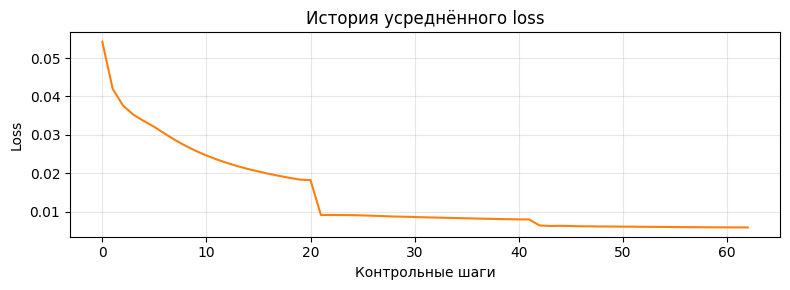

In [ ]:
if history:
    history_df = pd.DataFrame(history)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(history_df['epoch'], history_df['train_loss'], marker='o', color='tab:orange')
    axes[0].set_title('Loss по эпохам')
    axes[0].set_xlabel('Эпоха')
    axes[0].set_ylabel('Loss')
    axes[1].plot(history_df['epoch'], history_df['val_f1'] * 100, marker='o', label='Val F1')
    axes[1].plot(history_df['epoch'], history_df['train_f1'] * 100, marker='o', label='Train F1 (sample)')
    axes[1].set_title('F1 по эпохам')
    axes[1].set_xlabel('Эпоха')
    axes[1].set_ylabel('F1, %')
    axes[1].legend()
    plt.tight_layout()
    plt.show()

#### Итоговая оценка

Рассчитываем F1 на полном обучающем и валидационном множествах.

In [ ]:
final_train_f1 = evaluate_model_full(model, train_df)
final_val_f1 = evaluate_model_full(model, val_df)
logger.info('Финальные метрики: train F1 %.2f, val F1 %.2f', final_train_f1 * 100, final_val_f1 * 100)
final_train_f1, final_val_f1

2025-09-24 09:57:45,167 INFO: Финальные F1: train 87.23, val 86.80


(0.8722953314030896, 0.8680388554719392)

Фиксируем строки с минимальными значениями F1, чтобы понять типичные ошибки модели и уточнить параметры аугментации.

In [ ]:
def build_details(df: pd.DataFrame, preds: Sequence[Sequence[int]]) -> pd.DataFrame:
    '''
    Собирает подробный отчет по precision/recall/F1 для каждой строки.

    Parameters
    ----------
    df : pd.DataFrame
        Датафрейм с колонками `no_space` и `true_positions`.
    preds : Sequence[Sequence[int]]
        Предсказанные позиции пробелов.

    Returns
    -------
    pd.DataFrame
        Датафрейм с метриками и восстановленными текстами.
    '''
    rows: list[dict[str, object]] = []
    for no_space, gold, pred in zip(df['no_space'], df['true_positions'], preds):
        gold_set = set(gold)
        pred_set = set(pred)
        tp = len(gold_set & pred_set)
        fp = len(pred_set - gold_set)
        fn = len(gold_set - pred_set)
        precision = tp / (tp + fp) if (tp + fp) else 0.0
        recall = tp / (tp + fn) if (tp + fn) else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.0
        rows.append({
            'len': len(no_space),
            'n_true': len(gold),
            'n_pred': len(pred),
            'tp': tp,
            'fp': fp,
            'fn': fn,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'no_space': no_space,
            'true_positions': gold,
            'pred_positions': pred,
            'gold_text': apply_positions(no_space, gold),
            'pred_text': apply_positions(no_space, pred),
        })
    return pd.DataFrame(rows)


val_predictions = decode_positions_batch(model, val_df['no_space'].tolist())
val_details = build_details(val_df, val_predictions)
val_details.nsmallest(5, 'f1')[['no_space', 'gold_text', 'pred_text', 'f1']]

In [ ]:
if not val_details.empty:
    plt.figure(figsize=(8, 3))
    val_details['f1'].plot(kind='hist', bins=40, color='tab:green', alpha=0.75)
    plt.xlabel('F1 на валидации')
    plt.title('Распределение F1 по примерам валидации')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 3))
    grouped = val_details.groupby(pd.qcut(val_details['len'], q=8, duplicates='drop'))['f1'].mean()
    grouped.plot(marker='o', color='tab:purple')
    plt.ylabel('Средний F1')
    plt.xlabel('Диапазон длины компактной строки')
    plt.title('Зависимость F1 от длины строки')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    logger.warning('val_details пуст, графики F1 не построены')

In [ ]:
print(f'Вес чекпоинта (ГБ): {CKPT_PATH.stat().st_size / 1e9:.3f}')

Вес чекпоинта (ГБ): 0.153


## Делаем submission

Следующий раздел можно запускать отдельно - он повторно импортирует библиотеки, создаёт все необходимые функции и никак не зависит от предыдущих ячеек. Достаточно указать путь к файлу с тестовыми примерами и к сохранённому чекпоинту.

In [8]:
import json as _json_infer
import math as _math_infer
import re as _re_infer
import time as _time_infer
import logging as _logging_infer
import unicodedata as _unicodedata_infer
from collections.abc import Sequence as _Sequence_infer
from pathlib import Path as _Path_infer

import numpy as _np_infer
import pandas as _pd_infer
import torch as _torch_infer
import torch.nn as _nn_infer
from tqdm.auto import tqdm as _tqdm_infer
import csv as _csv_infer


_INFER_SPACES = _re_infer.compile(r'\s+')

INFER_MAX_TOKENS = 512
INFER_LEFT_CTX = 64
INFER_RIGHT_CTX = 64
INFER_DEVICE = 'cuda' if _torch_infer.cuda.is_available() else 'cpu'

INFER_LOGGER = _logging_infer.getLogger('whitespace_infer')
INFER_LOGGER.setLevel(_logging_infer.INFO)

INFER_SUBMISSION_CSV = _Path_infer('submission.csv')            
INFER_RESTORED_TXT = _Path_infer('restored_texts.txt')         
INFER_BATCH_SIZE = 64

INFER_INPUT_TXT = _Path_infer('dataset_1937770_3.txt')  
INFER_CHECKPOINT = _Path_infer('experiments/eo_byte_finetune/checkpoint_epoch_3.pt')

In [9]:
def _infer_apply_positions(no_space: str, positions: _Sequence_infer[int]) -> str:
    '''
    Восстанавливает пробелы в строке на основании списка индексов

    Parameters
    ----------
    no_space : str
        Строка без пробелов
    positions : Sequence[int]
        Индексы, в которых нужно вставить пробелы

    Returns
    -------
    str
        Строка с восстановленными пробелами
    '''
    insert_positions = {int(p) for p in positions}
    buf: list[str] = []
    for i, ch in enumerate(no_space):
        if i in insert_positions:
            buf.append(' ')
        buf.append(ch)
    if len(no_space) in insert_positions:
        buf.append(' ')
    return _INFER_SPACES.sub(' ', ''.join(buf)).strip()


def _infer_grapheme_spans(text: str) -> tuple[str, list[tuple[int, int]]]:
    '''
    Разбивает строку на графемы после нормализации

    Parameters
    ----------
    text : str
        Исходная строка

    Returns
    -------
    tuple[str, list[tuple[int, int]]]
        Нормализованный текст и интервалы графем
    '''
    normalized = _unicodedata_infer.normalize('NFKC', text)
    spans: list[tuple[int, int]] = []
    start = 0
    for idx in range(1, len(normalized)):
        if _unicodedata_infer.combining(normalized[idx]):
            continue
        spans.append((start, idx))
        start = idx
    spans.append((start, len(normalized)))
    return normalized, spans


def _infer_token_byte_lengths(norm_text: str, spans: _Sequence_infer[tuple[int, int]]) -> _np_infer.ndarray:
    '''
    Возвращает длину каждой графемы в байтах UTF-8

    Parameters
    ----------
    norm_text : str
        Нормализованный текст
    spans : Sequence[tuple[int, int]]
        Диапазоны графем

    Returns
    -------
    numpy.ndarray
        Массив длин в байтах для каждой графемы
    '''
    return _np_infer.fromiter((len(norm_text[start:end].encode('utf-8', errors='ignore')) for start, end in spans), dtype=_np_infer.int32)


def _infer_bytes_for_string(text: str) -> _np_infer.ndarray:
    '''
    Переводит строку в массив байтов UTF-8

    Parameters
    ----------
    text : str
        Исходная строка

    Returns
    -------
    numpy.ndarray
        Массив байтовых значений
    '''
    return _np_infer.frombuffer(text.encode('utf-8', errors='ignore'), dtype=_np_infer.uint8).copy()


def _infer_make_token_windows(num_tokens: int, *, max_tokens: int, left_ctx: int, right_ctx: int) -> list[tuple[int, int, int, int]]:
    '''
    Делит последовательность графем на окна с контекстом

    Parameters
    ----------
    num_tokens : int
        Количество графем
    max_tokens : int
        Максимальная длина окна
    left_ctx : int
        Размер левого контекста
    right_ctx : int
        Размер правого контекста

    Returns
    -------
    list[tuple[int, int, int, int]]
        Список окон (start, end, core_start, core_end)
    '''
    if num_tokens <= max_tokens:
        return [(0, num_tokens, 0, num_tokens)]
    core = max_tokens - left_ctx - right_ctx
    if core <= 0:
        raise ValueError('Контекст не может быть больше окна')
    windows: list[tuple[int, int, int, int]] = []
    start = 0
    while start < num_tokens:
        core_start = start
        core_end = min(start + core, num_tokens)
        win_start = max(0, core_start - left_ctx)
        win_end = min(num_tokens, core_end + right_ctx)
        core_rel_start = core_start - win_start
        core_rel_end = core_end - win_start
        windows.append((win_start, win_end, core_rel_start, core_rel_end))
        start = core_end
    return windows


def _infer_labels_to_positions(norm_text: str, spans: _Sequence_infer[tuple[int, int]], labels: _Sequence_infer[int]) -> list[int]:
    '''
    Преобразует метки классов в индексы вставки пробелов

    Parameters
    ----------
    norm_text : str
        Нормализованный текст
    spans : Sequence[tuple[int, int]]
        Диапазоны графем
    labels : Sequence[int]
        Предсказанные метки

    Returns
    -------
    list[int]
        Список индексов пробелов
    '''
    positions: list[int] = []
    compact_idx = 0
    for label, (start, end) in zip(labels, spans):
        token = norm_text[start:end]
        if token.strip() == '':
            continue
        if label == 1 and compact_idx > 0:
            prev_char = norm_text[start - 1] if start > 0 else ''
            if prev_char != ' ':
                positions.append(compact_idx)
        compact_idx += 1
    return positions

In [10]:
class _InferSinusoidalPositionalEncoding(_nn_infer.Module):
    '''
    Синусоидальные позиционные кодировки для inference

    Parameters
    ----------
    d_model : int
        Размерность эмбеддингов
    max_len : int, optional
        Максимальная длина последовательности
    '''

    def __init__(self, d_model: int, max_len: int = 4096) -> None:
        super().__init__()
        position = _torch_infer.arange(0, max_len, dtype=_torch_infer.float32).unsqueeze(1)
        div_term = _torch_infer.exp(_torch_infer.arange(0, d_model, 2, dtype=_torch_infer.float32) * (-_math_infer.log(10000.0) / d_model))
        pe = _torch_infer.zeros(max_len, d_model)
        pe[:, 0::2] = _torch_infer.sin(position * div_term)
        pe[:, 1::2] = _torch_infer.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0), persistent=False)

    def forward(self, x: _torch_infer.Tensor) -> _torch_infer.Tensor:
        '''
        Добавляет позиционные кодировки к входному тензору

        Parameters
        ----------
        x : torch.Tensor
            Тензор формы (batch, seq_len, d_model)

        Returns
        -------
        torch.Tensor
            Тензор с позиционными кодировками
        '''
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]


class _InferEOByteTransformer(_nn_infer.Module):
    '''
    Encoder-only Transformer для автономного inference

    Parameters
    ----------
    d_model : int, optional
        Размерность эмбеддингов
    nhead : int, optional
        Количество голов внимания
    num_layers : int, optional
        Число слоев TransformerEncoder
    dim_ff : int, optional
        Размер скрытого слоя
    dropout : float, optional
        Доля дропаута
    max_len : int, optional
        Максимальная длина последовательности
    '''

    def __init__(self, d_model: int = 512, nhead: int = 8, num_layers: int = 12,
                 dim_ff: int = 2048, dropout: float = 0.1, max_len: int = 4096) -> None:
        super().__init__()
        self.byte_embed = _nn_infer.Embedding(256, d_model)
        encoder_layer = _nn_infer.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_ff,
            dropout=dropout,
            batch_first=True,
            norm_first=True,
        )
        self.encoder = _nn_infer.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.positional = _InferSinusoidalPositionalEncoding(d_model, max_len=max_len)
        self.head = _nn_infer.Linear(d_model, 3)

    def forward_prepared(self, byte_values: list[_torch_infer.Tensor], token_lengths: list[_torch_infer.Tensor]) -> tuple[_torch_infer.Tensor, _torch_infer.Tensor]:
        '''
        Выполняет прямой проход по уже подготовленным байтовым представлениям

        Parameters
        ----------
        byte_values : list[torch.Tensor]
            Батч байтовых представлений
        token_lengths : list[torch.Tensor]
            Длины графем для каждого образца

        Returns
        -------
        tuple[torch.Tensor, torch.Tensor]
            Логиты и маска допустимых позиций
        '''
        device = self.byte_embed.weight.device
        batch_size = len(byte_values)
        embedding_dim = self.byte_embed.embedding_dim
        max_tokens = max((int(lengths.numel()) for lengths in token_lengths), default=0)
        if max_tokens == 0:
            logits = _torch_infer.zeros((batch_size, 0, self.head.out_features), device=device)
            attn_mask = _torch_infer.zeros((batch_size, 0), dtype=_torch_infer.bool, device=device)
            return logits, attn_mask
        padded = _torch_infer.zeros((batch_size, max_tokens, embedding_dim), device=device)
        attn_mask = _torch_infer.zeros((batch_size, max_tokens), dtype=_torch_infer.bool, device=device)
        zero_vec = _torch_infer.zeros(embedding_dim, device=device)
        for idx, (byte_tensor, len_tensor) in enumerate(zip(byte_values, token_lengths)):
            lengths = len_tensor.to(device=device, dtype=_torch_infer.long, non_blocking=True)
            if lengths.numel() == 0:
                continue
            byte_tensor = byte_tensor.to(device=device, dtype=_torch_infer.long, non_blocking=True)
            embedded = self.byte_embed(byte_tensor)
            pointer = 0
            token_vectors: list[_torch_infer.Tensor] = []
            for length in lengths.tolist():
                if length <= 0:
                    token_vectors.append(zero_vec)
                    continue
                span = embedded[pointer:pointer + length]
                if span.numel() == 0:
                    token_vectors.append(zero_vec)
                else:
                    token_vectors.append(span.mean(dim=0))
                pointer += length
            if not token_vectors:
                token_vectors.append(zero_vec)
            stacked = _torch_infer.stack(token_vectors, dim=0)
            seq_len = stacked.size(0)
            padded[idx, :seq_len] = stacked
            attn_mask[idx, :seq_len] = True
        encoded = self.positional(padded)
        encoded = self.encoder(encoded, src_key_padding_mask=~attn_mask)
        logits = self.head(encoded)
        return logits, attn_mask

    def decode_positions(self, text: str, *, max_tokens: int = INFER_MAX_TOKENS,
                         left_ctx: int = INFER_LEFT_CTX, right_ctx: int = INFER_RIGHT_CTX) -> list[int]:
        '''
        Декодирует индексы пробелов для одной строки

        Parameters
        ----------
        text : str
            Строка без пробелов
        max_tokens : int, optional
            Максимальная длина окна
        left_ctx : int, optional
            Размер левого контекста
        right_ctx : int, optional
            Размер правого контекста

        Returns
        -------
        list[int]
            Предсказанные индексы пробелов
        '''
        norm_text, spans = _infer_grapheme_spans(text)
        if not spans:
            return []
        labels: list[int] = []
        token_lengths = _infer_token_byte_lengths(norm_text, spans)
        byte_buffer = _infer_bytes_for_string(norm_text)
        offsets = _np_infer.concatenate((_np_infer.array([0], dtype=_np_infer.int64), _np_infer.cumsum(token_lengths, dtype=_np_infer.int64)))
        for win_start, win_end, core_rel_start, core_rel_end in _infer_make_token_windows(len(spans), max_tokens=max_tokens, left_ctx=left_ctx, right_ctx=right_ctx):
            byte_start = int(offsets[win_start])
            byte_end = int(offsets[win_end])
            chunk_bytes = _torch_infer.from_numpy(byte_buffer[byte_start:byte_end].astype(_np_infer.int64, copy=True))
            chunk_lengths = _torch_infer.from_numpy(token_lengths[win_start:win_end].astype(_np_infer.int64, copy=True))
            logits, attn = self.forward_prepared([chunk_bytes.to(self.byte_embed.weight.device)], [chunk_lengths.to(self.byte_embed.weight.device)])
            preds = logits[0].argmax(dim=-1)
            valid = attn[0]
            labels.extend(preds[valid].tolist()[core_rel_start:core_rel_end])
        labels = labels[:len(spans)]
        return _infer_labels_to_positions(norm_text, spans, labels)

In [11]:
def infer_decode_positions_batch(model: _InferEOByteTransformer, texts: list[str], *,
                                 max_tokens: int = INFER_MAX_TOKENS,
                                 left_ctx: int = INFER_LEFT_CTX,
                                 right_ctx: int = INFER_RIGHT_CTX,
                                 batch_size: int = 64) -> list[list[int]]:
    '''
    Выполняет пакетное декодирование индексов пробелов для списка строк

    Parameters
    ----------
    model : _InferEOByteTransformer
        Модель для inference
    texts : list[str]
        Список строк без пробелов
    max_tokens : int, optional
        Максимальная длина окна
    left_ctx : int, optional
        Размер левого контекста
    right_ctx : int, optional
        Размер правого контекста
    batch_size : int, optional
        Размер пакета при декодировании

    Returns
    -------
    list[list[int]]
        Предсказанные индексы пробелов для каждой строки
    '''
    predictions: list[list[int]] = []
    for start in range(0, len(texts), batch_size):
        batch = texts[start:start + batch_size]
        batch_preds = [model.decode_positions(text, max_tokens=max_tokens, left_ctx=left_ctx, right_ctx=right_ctx) for text in batch]
        predictions.extend(batch_preds)
    return predictions


def _infer_load_model(path: _Path_infer) -> _InferEOByteTransformer:
    if not path.exists():
        raise FileNotFoundError(f'Нет чекпоинта: {path}')
    payload = _torch_infer.load(path, map_location='cpu')
    cfg = payload.get('cfg', {})

    model = _InferEOByteTransformer(
        d_model=cfg.get('d_model', 512),
        nhead=cfg.get('nhead', 8),
        num_layers=cfg.get('num_layers', cfg.get('layers', 12)),
        dim_ff=cfg.get('dim_ff', 2048),
        dropout=cfg.get('dropout', 0.1),
        max_len=4096,
    ).to(INFER_DEVICE)

    sd = payload.get('state_dict', payload)
    if any(k.startswith('_orig_mod.') for k in sd.keys()):
        sd = {k.replace('_orig_mod.', '', 1): v for k, v in sd.items()}

    if 'head.weight' in sd:
        num_classes = sd['head.weight'].shape[0]
        if model.head.out_features != num_classes:
            model.head = _nn_infer.Linear(model.head.in_features, num_classes).to(INFER_DEVICE)

    missing, unexpected = model.load_state_dict(sd, strict=False)
    if missing:
        INFER_LOGGER.warning('Отсутствуют ключи: %s', missing)
    if unexpected:
        INFER_LOGGER.warning('Лишние ключи: %s', unexpected)

    model.eval()
    return model


def _infer_read_input(path: _Path_infer) -> _pd_infer.DataFrame:
    '''
    Читает входной txt с форматом "id,<текст_без_пробелов>".

    Parameters
    ----------
    path : pathlib.Path
        Путь к входному файлу.

    Returns
    -------
    pandas.DataFrame
        Таблица с колонками: ["id", "text_no_spaces"].
    '''
    if not path.exists():
        raise FileNotFoundError(f'Нет входного файла {path}')
    rows = []
    with path.open('r', encoding='utf-8') as fin:
        for ln, line in enumerate(fin, 1):
            line = line.rstrip('\n\r')
            if not line:
                continue
            cpos = line.find(',')
            if cpos == -1:
                continue
            id_part = line[:cpos].strip()
            text_part = line[cpos + 1:].strip()
            # пропускаем возможный заголовок
            if ln == 1 and id_part.lower() in {'id', '"id"'}:
                continue
            if not id_part or not text_part:
                continue
            rows.append({
                'id': id_part,
                'text_raw': text_part,                
                'text_no_spaces': _INFER_SPACES.sub('', text_part)  
            })
    return _pd_infer.DataFrame(rows)


def _infer_batch_decode(model: _InferEOByteTransformer, texts: list[str], batch_size: int) -> list[list[int]]:
    '''
    Пакетно декодирует позиции пробелов для списка строк.

    Parameters
    ----------
    model : _InferEOByteTransformer
        Модель инференса.
    texts : list[str]
        Строки без пробелов.
    batch_size : int
        Размер батча.

    Returns
    -------
    list[list[int]]
        Список массивов позиций пробелов для каждой строки.
    '''
    out: list[list[int]] = []
    for start in _tqdm_infer(range(0, len(texts), batch_size), desc='inference', unit='batch'):
        batch = texts[start:start + batch_size]
        out.extend([model.decode_positions(t) for t in batch])
    return out

In [12]:
model = _infer_load_model(INFER_CHECKPOINT)
df = _infer_read_input(INFER_INPUT_TXT)
texts = df['text_no_spaces'].astype(str).tolist()


if INFER_DEVICE == 'cuda':
    _torch_infer.cuda.synchronize()
t0 = _time_infer.perf_counter()

preds = _infer_batch_decode(model, texts, INFER_BATCH_SIZE)

if INFER_DEVICE == 'cuda':
    _torch_infer.cuda.synchronize()
dt = _time_infer.perf_counter() - t0

INFER_LOGGER.info('Инференс: %.2f c (%.2f строк/с)', dt, len(texts) / max(dt, 1e-6))

/home/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
inference: 100%|██████████| 16/16 [00:06<00:00,  2.30batch/s]


In [13]:
df['predicted_positions'] = preds

def _pos_to_str(pos):
    if not pos:
        return "[]"
    vals = sorted({int(x) for x in pos})
    return "[" + ", ".join(str(v) for v in vals) + "]"

df_out = _pd_infer.DataFrame({
    'id': df['id'].astype(str),
    'text_no_spaces': df['text_raw'],  
    'predicted_positions': [_pos_to_str(p) for p in df['predicted_positions']]
})

df_out.to_csv(INFER_SUBMISSION_CSV, index=False, encoding='utf-8', quoting=_csv_infer.QUOTE_MINIMAL)

with INFER_RESTORED_TXT.open('w', encoding='utf-8') as fout:
    for row, pos in zip(df.itertuples(index=False), preds):
        restored = _infer_apply_positions(str(row.text_no_spaces), pos)
        fout.write(f'{row.id},{restored}\n')

INFER_LOGGER.info('Сохранено: %s  (rows=%d)', INFER_SUBMISSION_CSV, len(df_out))

## Выводы

In [14]:
IPYNB_TIME_END = time.time()

full_time = IPYNB_TIME_END - IPYNB_TIME_START
logger.info('Время выполнения ноутбука: %.2f минут (%.2f часов)', full_time / 60, full_time / 3600)

NameError: name 'time' is not defined

Новый подход, который мы адаптировали из статьи, сделал наше решение быстрым и лёгким, что идеально подходит для продакшен-сценариев с ограниченными ресурсами